In [1]:
1+1

2

# The doubling population

Let's play with very simple scenario with a few (simple) mathematical models. The purpose of this exploration is not necessarily to explore the models, but rather to see various bits of Julia syntax and style for dealing with basic analysis.

**Say we observe or believe that every day the population doubles (and there are no deaths)**

Here are some 6 different models for this ...

### Model 1 (discrete time/deterministic)

$$
x(t+1) = \alpha x(t)
$$

with $\alpha = 2$.

### Model 2 (continuous time/deterministic)

$$
\frac{d}{dt} x(t) = \kappa x(t)
$$

with $\kappa = \log(\alpha) = \log(2) \approx 0.693$.

### Model 3 (discrete time/stochastic)

$$
x(t+1) = \sum_{i=1}^{x(t)} \xi_{i,t}
$$

with $E[\xi_{i,t}] = \alpha = 2$.

### Model 4 (continuous time/stochastic/continuous trajectory)

$$
du(t) = \kappa u(t) + d \zeta(t).
$$

with $u(t) \sim \text{Normal}(x(0),1)$ and $x(t) = \max(u(t),0)$.

### Model 5 (continuous time/stochastic/discrete trajectory)

A continuous time markov chain with transition rates: $x \to x+1$ at rate $\kappa x$.

### Model 6 (continuous time/stochastic/discrete trajectory/non-Markovian)

A continuous time processs where each doubling per agent has their own distribution. Each agent lives for a duration which is $1$ day on average and then doubles.

---

Let's create trajectories for each of these models over the time horizon $[0,7]$. For the stochastic models lets compute mean trajectories. For those models let's also look at the distribution of $x(t=7)$. 

---

In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/git/mine/Workshop_Julia_for_Biologists`


In [3]:
using Plots, DifferentialEquations, Distributions, Random
using StatsPlots, DataFrames, CSV, StatsBase
using DataStructures

In [5]:
δ = 3
ϵ = 7
δ + ϵ

10

In [6]:
const α_const = 2 #\alpha + [TAB]
const κ_const = log(2) #\kappa + [TAB]
const default_t_max = 7
const default_x0 = 1.0;

In [8]:
"""
A generic structure that represents a model trajectory. 

* `t` is treated as an indexable object (array) of times.
* `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`
"""
struct ModelTrajectory
    t
    u
end;

In [9]:
? ModelTrajectory

search: ModelTrajectory



A generic structure that represents a model trajectory. 

  * `t` is treated as an indexable object (array) of times.
  * `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`


In [14]:
x = Float16(2.0)

Float16(2.0)

In [15]:
typeof(x)

Float16

In [16]:
f(x) = x^2 #**

f (generic function with 1 method)

In [17]:
f(2.0)

4.0

In [18]:
typeof(ans)

Float64

In [19]:
f(2)

4

In [20]:
typeof(ans)

Int64

In [21]:
f("Lisi")

"LisiLisi"

In [24]:
"Lisi" * "Lisi"

"LisiLisi"

In [22]:
"Lisi" + "Lisi"

LoadError: MethodError: no method matching +(::String, ::String)
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  +([91m::VectorizationBase.CartesianVIndex[39m, ::Any) at ~/.julia/packages/VectorizationBase/e4FnQ/src/cartesianvindex.jl:67
[0m  +([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at ~/.julia/packages/ChainRulesCore/C73ay/src/tangent_arithmetic.jl:122
[0m  ...

# Multiple Dispatch

In [23]:
methods(f)

# 1 method for generic function "f":
[1] f(x) in Main at In[16]:1

In [25]:
f(x::String) = x*" "*x

f (generic function with 2 methods)

In [26]:
f(3.0)

9.0

In [27]:
f("Lisi")

"Lisi Lisi"

In [28]:
methods(f)

# 2 methods for generic function "f":
[1] f(x::String) in Main at In[25]:1
[2] f(x) in Main at In[16]:1

In [29]:
f(x::Float64) = -1.0

f (generic function with 3 methods)

In [30]:
f(4)

16

In [32]:
f(3.14)

-1.0

In [33]:
π

π = 3.1415926535897...

In [34]:
typeof(ans)

Irrational{:π}

In [35]:
"""
Create a trajectory for model 1.
"""
function model_1_traj(;t_max = default_t_max, x0 = default_x0)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        x *= α_const #x = x + α_const
        traj[t] = x
    end
    ModelTrajectory(0:t_max, traj)
end;

In [37]:
traj1 = model_1_traj()

ModelTrajectory(0:7, [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0])

In [38]:
traj1.t

0:7

In [39]:
typeof(ans)

UnitRange{Int64}

In [ ]:
traj1.t, traj1.u

In [44]:
typeof(:lisi)

Symbol

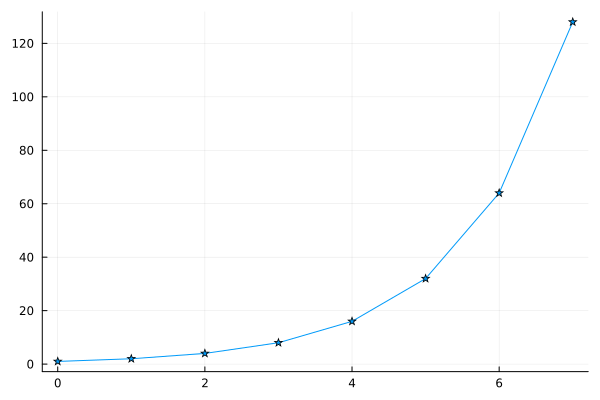

In [48]:
plot(traj1.t, traj1.u,legend=false,marker=:star)

Let's create a function for querying/interpolating a trajectory at any given time (within the time range).

In [56]:
using LinearAlgebra

In [60]:
iseven(7)

false

In [65]:
findfirst(iseven, [3,16,5,8,3])

2

In [66]:
findfirst((x)->(x>8), [3,16,5,8,3]) #-> annon' function

2

In [58]:
methods(findfirst)

# 17 methods for generic function "findfirst":
[1] findfirst(p::Union{Base.Fix2{typeof(==), Int64}, Base.Fix2{typeof(isequal), Int64}}, r::Base.OneTo{Int64}) in Base at array.jl:2077
[2] findfirst(p::Union{Base.Fix2{typeof(==), T}, Base.Fix2{typeof(isequal), T}}, r::AbstractUnitRange) where T<:Integer in Base at array.jl:2080
[3] findfirst(p::Union{Base.Fix2{typeof(==), T}, Base.Fix2{typeof(isequal), T}}, r::StepRange{T, S}) where {T, S} in Base at array.jl:2083
[4] findfirst(pred::Base.Fix2{<:Union{typeof(==), typeof(isequal)}, <:Union{Int8, UInt8}}, a::Union{Base.CodeUnits{UInt8, String}, Vector{Int8}, Vector{UInt8}, SubArray{Int8, 1, Vector{Int8}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}, SubArray{UInt8, 1, Base.CodeUnits{UInt8, String}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}, SubArray{UInt8, 1, Vector{UInt8}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}}) in Base at strings/search.jl:22
[5] findfirst(f::Function, t::Tuple) in Base at tuple.jl:368
[6] findfirst(f::Function, x::SentinelArrays.ChainedVector) in SentinelArrays at /Users/uqjnazar/.julia/packages/SentinelArrays/XvFr7/src/chainedvector.jl:840
[7] findfirst(f::Function, itr::DataFrames.DataFrameColumns) in DataFrames at /Users/uqjnazar/.julia/packages/DataFrames/KKiZW/src/abstractdataframe/iteration.jl:251
[8] findfirst(x::SentinelArrays.ChainedVector{Bool, A} where A<:AbstractVector{Bool}) in SentinelArrays at /Users/uqjnazar/.julia/packages/SentinelArrays/XvFr7/src/chainedvector.jl:849
[9] findfirst(pattern::AbstractVector{<:Union{Int8, UInt8}}, A::AbstractVector{<:Union{Int8, UInt8}}) in Base at strings/search.jl:148
[10] findfirst(A::AbstractArray) in Base at array.jl:1992
[11] findfirst(ch::AbstractChar, string::AbstractString) in Base at strings/search.jl:130
[12] findfirst(pattern::AbstractString, string::AbstractString) in Base at strings/search.jl:110
[13] findfirst(::typeof(iszero), a::Union{Base.CodeUnits{UInt8, String}, Vector{Int8}, Vector{UInt8}, SubArray{Int8, 1, Vector{Int8}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}, SubArray{UInt8, 1, Base.CodeUnits{UInt8, String}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}, SubArray{UInt8, 1, Vector{UInt8}, I, true} where I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}}) in Base at strings/search.jl:28
[14] findfirst(testf::Function, A::Union{AbstractString, AbstractArray}) in Base at array.jl:2074
[15] findfirst(testf::Function, A) in Base at array.jl:2066
[16] findfirst(r::Regex, s::AbstractString) in Base at regex.jl:435
[17] findfirst(A) in Base at array.jl:1989

In [57]:
? findfirst

search: findfirst



```
findfirst(A)
```

Return the index or key of the first `true` value in `A`. Return `nothing` if no such value is found. To search for other kinds of values, pass a predicate as the first argument.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

See also: [`findall`](@ref), [`findnext`](@ref), [`findlast`](@ref), [`searchsortedfirst`](@ref).

# Examples

```jldoctest
julia> A = [false, false, true, false]
4-element Vector{Bool}:
 0
 0
 1
 0

julia> findfirst(A)
3

julia> findfirst(falses(3)) # returns nothing, but not printed in the REPL

julia> A = [false false; true false]
2×2 Matrix{Bool}:
 0  0
 1  0

julia> findfirst(A)
CartesianIndex(2, 1)
```

---

```
findfirst(predicate::Function, A)
```

Return the index or key of the first element of `A` for which `predicate` returns `true`. Return `nothing` if there is no such element.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

# Examples

```jldoctest
julia> A = [1, 4, 2, 2]
4-element Vector{Int64}:
 1
 4
 2
 2

julia> findfirst(iseven, A)
2

julia> findfirst(x -> x>10, A) # returns nothing, but not printed in the REPL

julia> findfirst(isequal(4), A)
2

julia> A = [1 4; 2 2]
2×2 Matrix{Int64}:
 1  4
 2  2

julia> findfirst(iseven, A)
CartesianIndex(2, 1)
```

---

```
findfirst(pattern::AbstractString, string::AbstractString)
findfirst(pattern::AbstractPattern, string::String)
```

Find the first occurrence of `pattern` in `string`. Equivalent to [`findnext(pattern, string, firstindex(s))`](@ref).

# Examples

```jldoctest
julia> findfirst("z", "Hello to the world") # returns nothing, but not printed in the REPL

julia> findfirst("Julia", "JuliaLang")
1:5
```

---

```
findfirst(ch::AbstractChar, string::AbstractString)
```

Find the first occurrence of character `ch` in `string`.

!!! compat "Julia 1.3"
    This method requires at least Julia 1.3.


# Examples

```jldoctest
julia> findfirst('a', "happy")
2

julia> findfirst('z', "happy") === nothing
true
```

---

```
findfirst(pattern::AbstractVector{<:Union{Int8,UInt8}},
          A::AbstractVector{<:Union{Int8,UInt8}})
```

Find the first occurrence of sequence `pattern` in vector `A`.

!!! compat "Julia 1.6"
    This method requires at least Julia 1.6.


# Examples

```jldoctest
julia> findfirst([0x52, 0x62], [0x40, 0x52, 0x62, 0x63])
2:3
```


In [67]:
? @assert

```
@assert cond [text]
```

Throw an [`AssertionError`](@ref) if `cond` is `false`. Preferred syntax for writing assertions. Message `text` is optionally displayed upon assertion failure.

!!! warning
    An assert might be disabled at various optimization levels. Assert should therefore only be used as a debugging tool and not used for authentication verification (e.g., verifying passwords), nor should side effects needed for the function to work correctly be used inside of asserts.


# Examples

```jldoctest
julia> @assert iseven(3) "3 is an odd number!"
ERROR: AssertionError: 3 is an odd number!

julia> @assert isodd(3) "What even are numbers?"
```


In [68]:
@assert 5==3

LoadError: AssertionError: 5 == 3

In [49]:
function value_at_time(mt, time::Real) #mt is like ModelTrajectory assumed to have fields t, and u
    time < first(mt.t) && error("Time preceeds trajectory")
#     if time < first(mt.t)
#         error("Time preceeds trajectory")
#     end
    
    i = findfirst((t)->t≥time, mt.t)  #\ge + [TAB]
    i == nothing && error("Time exceeds trajectory")
    t1, u1 = mt.t[i], mt.u[i]
    
    #if exact match of time 
    t1 == time && return u1

    #If here then interporlate
    @assert i > 1
    iprev = i-1
    tprev, uprev = mt.t[iprev], mt.u[iprev]
    return uprev + (time-tprev)/(t1-tprev) * (u1-uprev) #interpolate  
end

value_at_time (generic function with 1 method)

In [70]:
x = 3
@show x;

x = 3


In [71]:
println(x)

3


In [55]:
value_at_time(traj1,-7)

LoadError: Time preceeds trajectory

In [53]:
value_at_time(traj1,0.0)

1.0

In [72]:
data =[1,2,3]
@show mean(data)

mean(data) = 2.0


2.0

In [ ]:
print(f"{x=}")
@show x

In [74]:
a = 1; b =2;
c = a+b
@show c

c = 3


3

In [75]:
!true

false

In [76]:
data = rand(10^7);

In [77]:
sort(data)

10000000-element Vector{Float64}:
 6.585005263293198e-8
 3.8998016971270033e-7
 4.627702813175816e-7
 5.66443514204984e-7
 6.981805553696319e-7
 7.324478087378239e-7
 7.60934877885866e-7
 8.905043034079796e-7
 9.368546259880262e-7
 9.589209493121587e-7
 1.0417212578106572e-6
 1.0781532352455159e-6
 1.1656947189742084e-6
 ⋮
 0.9999989086262903
 0.9999989540644524
 0.9999990847350466
 0.9999991038917433
 0.9999991674212421
 0.9999994056859893
 0.9999994837098263
 0.9999995135952364
 0.9999995662508935
 0.9999996177679179
 0.9999996416374035
 0.9999998047821845

In [78]:
first(data,5)

5-element Vector{Float64}:
 0.6335433149220716
 0.12439640579973377
 0.6547433857068478
 0.4588786206982921
 0.10497939725785721

In [80]:
sort!(data)

10000000-element Vector{Float64}:
 6.585005263293198e-8
 3.8998016971270033e-7
 4.627702813175816e-7
 5.66443514204984e-7
 6.981805553696319e-7
 7.324478087378239e-7
 7.60934877885866e-7
 8.905043034079796e-7
 9.368546259880262e-7
 9.589209493121587e-7
 1.0417212578106572e-6
 1.0781532352455159e-6
 1.1656947189742084e-6
 ⋮
 0.9999989086262903
 0.9999989540644524
 0.9999990847350466
 0.9999991038917433
 0.9999991674212421
 0.9999994056859893
 0.9999994837098263
 0.9999995135952364
 0.9999995662508935
 0.9999996177679179
 0.9999996416374035
 0.9999998047821845

In [81]:
first(data,5)

5-element Vector{Float64}:
 6.585005263293198e-8
 3.8998016971270033e-7
 4.627702813175816e-7
 5.66443514204984e-7
 6.981805553696319e-7

In [79]:
!true

false

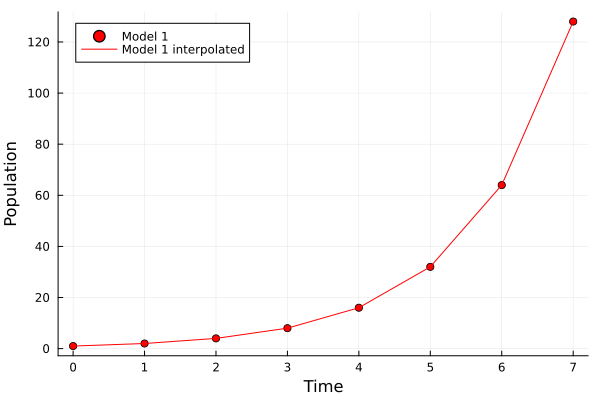

In [54]:
#Plotting Model 1
t_grid = 0:0.01:default_t_max
traj1_on_grid = [value_at_time(traj1,t1) for t1 in t_grid] 
p1 = scatter(traj1.t, traj1.u, 
            c=:red, legend=:topleft, xticks=0:7,
            label="Model 1", xlabel="Time", ylabel="Population")
p2 = plot(p1, t_grid, traj1_on_grid, c=:red,legend=:topleft,label="Model 1 interpolated")

### Moving onto Model 2, let's use ODE Solvers

In [10]:
function model_2_traj(;t_max = default_t_max, x0 = default_x0)
    f(x, p, t) = κ_const * x
    ode_prob = ODEProblem(f, x0, (0,t_max))
    ode_sol = solve(ode_prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)
    return ode_sol
end

model_2_traj (generic function with 1 method)

In [11]:
traj2 = model_2_traj()
traj2.t, traj2.u;

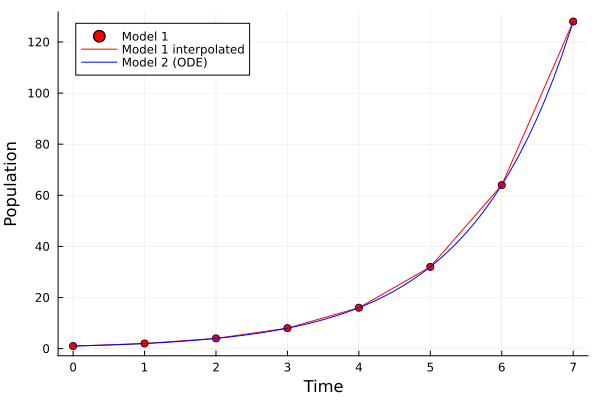

In [12]:
traj2_on_grid = [value_at_time(traj2,t1) for t1 in t_grid] 
p3 = plot(p2, t_grid, traj2_on_grid, c=:blue,legend=:topleft,label="Model 2 (ODE)")

# Going stochastic...

In [13]:
function model_3_traj(;t_max = default_t_max, 
                        x0 = default_x0, 
                        dist_by_mean_generator = Poisson,
                        seed::Union{Nothing,Int} = nothing)
    !isnothing(seed) && Random.seed!(seed)
    dist = dist_by_mean_generator(α_const)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        offsprings = [rand(dist) for _ in 1:x]
        x = isempty(offsprings) ? 0 : sum(offsprings)
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_3_traj (generic function with 1 method)

In [14]:
traj3 = model_3_traj()

ModelTrajectory(0:7, [1.0, 4.0, 5.0, 8.0, 14.0, 33.0, 72.0, 127.0])

In [82]:
[x^2 for x in 1:10]

10-element Vector{Int64}:
   1
   4
   9
  16
  25
  36
  49
  64
  81
 100

In [15]:
traj3_repeats = [model_3_traj().u for _ in 1:10^3]

1000-element Vector{Vector{Float64}}:
 [1.0, 2.0, 4.0, 6.0, 13.0, 27.0, 61.0, 113.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 2.0, 5.0, 9.0, 23.0, 54.0, 112.0, 212.0]
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 1.0, 1.0, 2.0, 5.0, 13.0, 31.0, 59.0]
 [1.0, 4.0, 16.0, 27.0, 54.0, 94.0, 171.0, 312.0]
 [1.0, 5.0, 8.0, 12.0, 33.0, 64.0, 147.0, 270.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 2.0, 4.0, 8.0, 14.0, 26.0, 56.0, 114.0]
 [1.0, 2.0, 3.0, 3.0, 5.0, 10.0, 16.0, 22.0]
 [1.0, 1.0, 4.0, 8.0, 22.0, 39.0, 82.0, 167.0]
 [1.0, 3.0, 8.0, 14.0, 31.0, 83.0, 145.0, 290.0]
 ⋮
 [1.0, 2.0, 3.0, 6.0, 8.0, 17.0, 34.0, 59.0]
 [1.0, 1.0, 3.0, 6.0, 13.0, 27.0, 55.0, 101.0]
 [1.0, 1.0, 2.0, 3.0, 11.0, 25.0, 47.0, 101.0]
 [1.0, 3.0, 8.0, 21.0, 42.0, 88.0, 176.0, 356.0]
 [1.0, 1.0, 3.0, 5.0, 10.0, 17.0, 34.0, 68.0]
 [1.0, 1.0, 5.0, 10.0, 24.0, 63.0, 124.0, 237.0]
 [1.0, 1.0, 5.0, 8.0, 19.0, 22.0, 44.0, 81.0]
 [1.0, 5.0, 9.0, 13.0, 31.0, 46.0, 

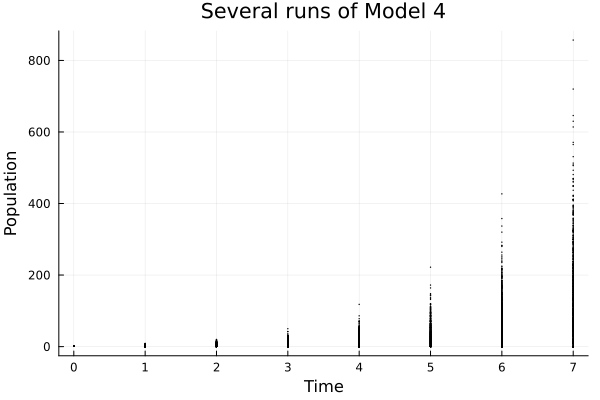

In [16]:
p4 = scatter(traj3.t, hcat(traj3_repeats...), 
        c=:black,ms=0.8,msw=0,legend=:topleft,label=false, xticks=0:7,
        xlabel="Time",ylabel="Population",
        title="Several runs of Model 4")

In [17]:
traj3_means = mean(traj3_repeats)

8-element Vector{Float64}:
   1.0
   1.945
   3.843
   7.714
  15.287
  30.589
  61.259
 122.749

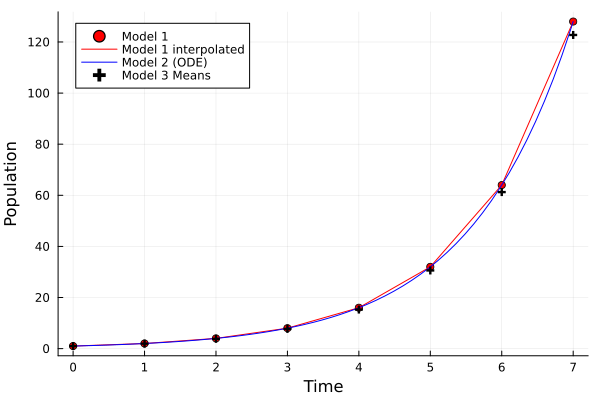

In [18]:
p4 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:cross,legend=:topleft,msw=3,label="Model 3 Means")

Let's increase to a million repeats

  5.493072 seconds (9.05 M allocations: 1.524 GiB, 8.69% gc time, 0.48% compilation time)


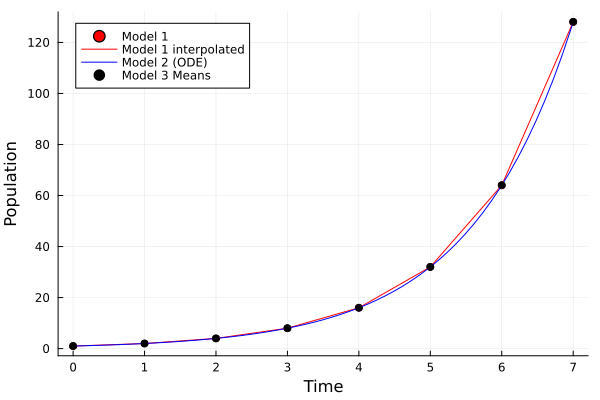

In [19]:
@time begin #See also BenchmarkTools.jl for better timing support
    traj3_repeats = [model_3_traj().u for _ in 1:10^6];
end
traj3_means = mean(traj3_repeats)
p5 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:black,legend=:topleft,msw=2,label="Model 3 Means")

### Now SDE

In [20]:
function model_4_traj(;t_max = default_t_max, x0 = default_x0, dt = 1//2^(4), positive_only = false)
    x0 = rand(Normal(x0, 1))
    f(u,p,t) = κ_const*u
    g(u,p,t) = u > 0 ? 1 : 0
    sode_prob = SDEProblem(f,g,x0,(0.0,t_max))
    sode_sol = solve(sode_prob, EM(), dt=dt)
    positive_only ? ModelTrajectory(sode_sol.t, map((u)->max(u,0), sode_sol.u) ) : sode_sol
end

model_4_traj (generic function with 1 method)

In [21]:
traj4_t = model_4_traj().t
first(traj4_t,5)

5-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25

In [22]:
traj4_repeats_a = [model_4_traj().u for _ in 1:10^2];
traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^2];

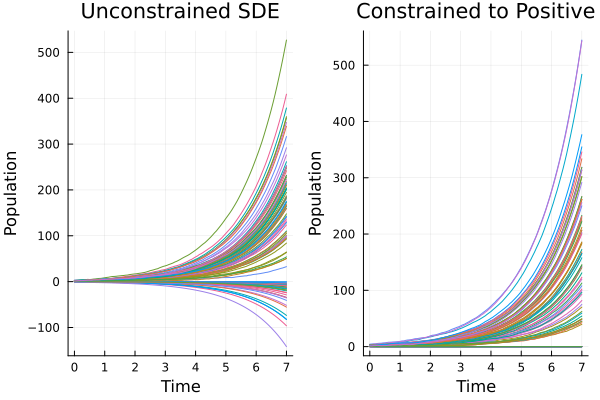

In [23]:
plot_args = (legend=false,xlabel="Time",ylabel="Population", xticks = 0:7)
pa = plot(traj4_t, hcat(traj4_repeats_a...), title = "Unconstrained SDE"; plot_args...)
pb = plot(traj4_t, hcat(traj4_repeats_b...), title = "Constrained to Positive"; plot_args...)
plot(pa,pb)

In [24]:
@time traj4_repeats_a = [model_4_traj().u for _ in 1:10^5];
@time traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^5];
@time traj4_means_a = mean(traj4_repeats_a)
@time traj4_means_b = mean(traj4_repeats_b)
first(traj4_means_a,3), first(traj4_means_b,3)

  1.965530 seconds (12.25 M allocations: 761.500 MiB, 8.23% gc time, 2.31% compilation time)
  2.458435 seconds (12.85 M allocations: 885.776 MiB, 7.96% gc time, 2.28% compilation time)
  0.043878 seconds (100.00 k allocations: 96.131 MiB)
  0.061784 seconds (100.00 k allocations: 96.131 MiB)


([1.000693942480124, 1.043688512133324, 1.0895799602938367], [1.0785642069315802, 1.128341030529717, 1.1810504158239854])

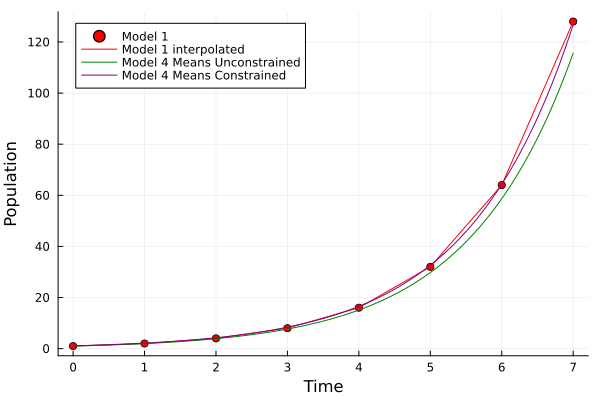

In [25]:
plot(p2, traj4_t, [traj4_means_a traj4_means_b], 
                c=[:green :purple], legend=:topleft, msw=0, 
                label=["Model 4 Means Unconstrained" "Model 4 Means Constrained"])

# Storing results/data in file

Say we want to store results at times:

In [26]:
times_of_results = [0.0, 2.5, 5.0, 5.9, 6.7]

5-element Vector{Float64}:
 0.0
 2.5
 5.0
 5.9
 6.7

In [27]:
model4df = DataFrame()
sims = [model_4_traj(positive_only=true) for _ in 1:10^4];
for time in times_of_results
    model4df[:,replace("Time$time","." => "_")] = [value_at_time(sim, time) for sim in sims]
end

In [28]:
names(model4df)

5-element Vector{String}:
 "Time0_0"
 "Time2_5"
 "Time5_0"
 "Time5_9"
 "Time6_7"

In [29]:
CSV.write("model4.csv",model4df)

"model4.csv"

### Continuous Time Markov Chain (Markov Jump Process)

In [30]:
function model_5_traj(;t_max = default_t_max, x0 = default_x0)
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_5_traj (generic function with 1 method)

In [31]:
traj5 = model_5_traj()
traj5.t, traj5.u

([0.0, 1.8700366946245395, 2.1777979634571696, 2.1950898068837374, 2.5633096381047737, 2.8625347381791073, 3.0063852573422, 3.0080248564163115, 3.146894794428657, 3.4570664497153762  …  6.914246029613834, 6.9207355439308245, 6.923746633478014, 6.949176981949597, 6.966159404720553, 6.96737150738961, 6.970649089762373, 6.99211722899423, 6.99289028123407, 7.012912354071558], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0])

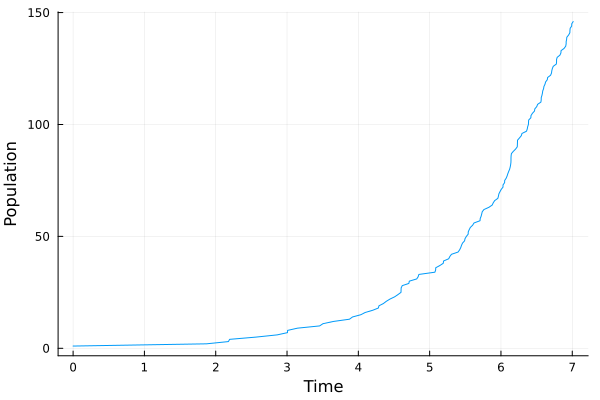

In [32]:
#Plotting of the trajectory for Model 5 - but something is a bit wrong... (what is it?)
plot(traj5.t, traj5.u;plot_args...)

In [33]:
#Function helping plotting
function stich_steps(model_trajectory)
    t, u = model_trajectory.t, model_trajectory.u
    n = length(t)
    new_t  = [ t[1] ]
    new_u = [ u[1] ]
    for i in 2:n
        push!(new_t, t[i])
        push!(new_u, u[i-1])
        push!(new_t, t[i])
        push!(new_u, u[i])
    end
    return ModelTrajectory(new_t, new_u)
end

stich_steps (generic function with 1 method)

In [34]:
traj5_stiched = stich_steps(traj5)

ModelTrajectory([0.0, 1.8700366946245395, 1.8700366946245395, 2.1777979634571696, 2.1777979634571696, 2.1950898068837374, 2.1950898068837374, 2.5633096381047737, 2.5633096381047737, 2.8625347381791073  …  6.96737150738961, 6.96737150738961, 6.970649089762373, 6.970649089762373, 6.99211722899423, 6.99211722899423, 6.99289028123407, 6.99289028123407, 7.012912354071558, 7.012912354071558], [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0  …  141.0, 142.0, 142.0, 143.0, 143.0, 144.0, 144.0, 145.0, 145.0, 146.0])

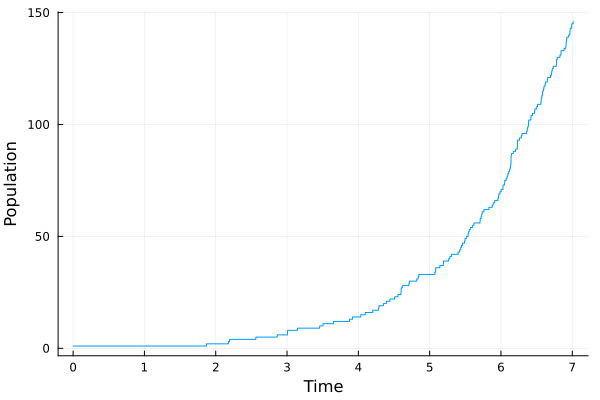

In [35]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

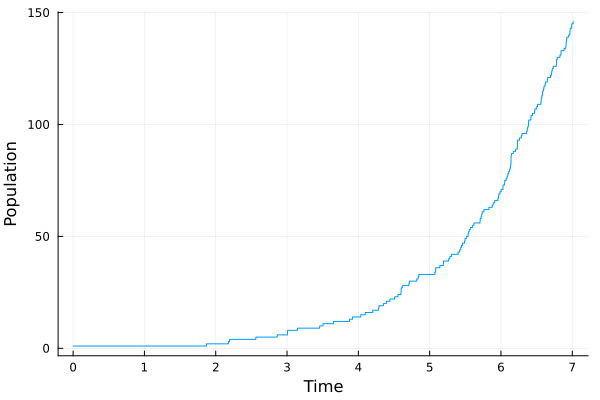

In [36]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

In [37]:
traj5_repeats = [model_5_traj() for _ in 1:10];
traj5_repeats_stiched = stich_steps.(traj5_repeats);

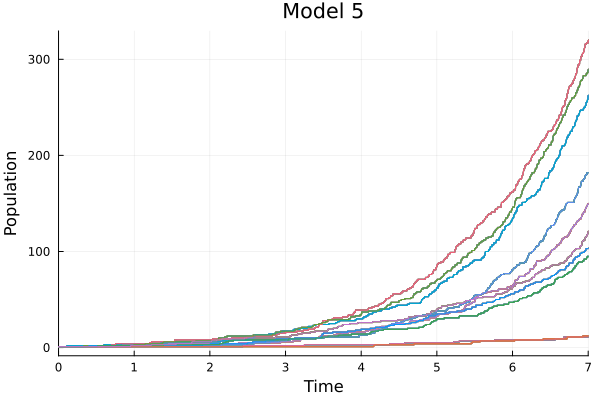

In [38]:
times = [mt.t for mt in traj5_repeats_stiched]
vals = [mt.u for mt in traj5_repeats_stiched]
p = plot(title = "Model 5")
for i in 1:length(times)
    plot!(times,vals;plot_args...,xlim=(0,7))
end
p

In [39]:
function value_at_time(mt, time::Real, jump_process::Bool=true) 
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    
    #if exact match of time 
    mt.t[i] == time && return mt.u[i]

    #Otherwise prev time...
    @assert i > 1
    return mt.u[i-1]    
end

value_at_time (generic function with 2 methods)

In [40]:
methods(value_at_time)

# 2 methods for generic function "value_at_time":
[1] value_at_time(mt, time::Real) in Main at In[39]:1
[2] value_at_time(mt, time::Real, jump_process::Bool) in Main at In[39]:1

In [41]:
Random.seed!(0)
traj5 = model_5_traj()

ModelTrajectory([0.0, 1.4555369011918016, 1.528580982636026, 1.9312783105482008, 2.048463811926414, 2.2645397537731813, 2.3632855702197126, 2.4085306574750978, 2.4325789130379603, 2.4518622060619695  …  6.946142846996933, 6.948893600367086, 6.95218686810082, 6.957170676074483, 6.9593554658737435, 6.959496504076371, 6.982206772066854, 6.990601021397845, 6.999642565836232, 7.005596967597079], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0])

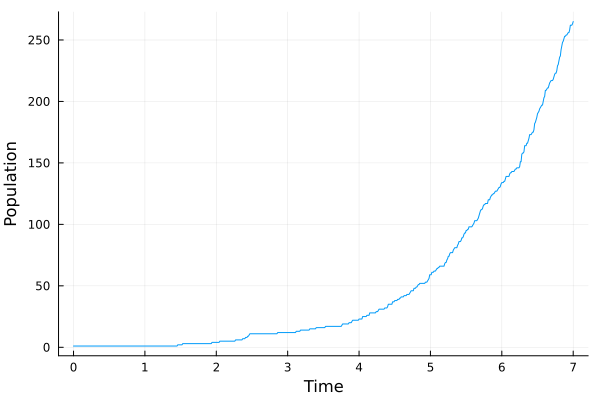

In [42]:
t_grid = 0:0.01:7
vals = [value_at_time(traj5, t ,true) for t in t_grid]
plot(t_grid,vals;plot_args...)

  0.141459 seconds (119.64 k allocations: 61.634 MiB, 54.38% gc time, 17.75% compilation time)


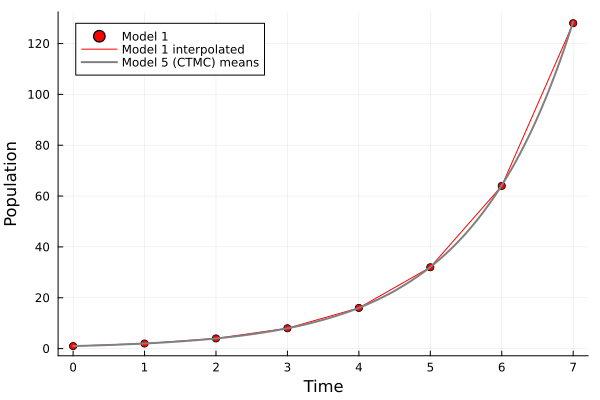

In [43]:
@time trajs = [model_5_traj() for _ in 1:10^4]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
plot(p2,t_grid,means,lw=2,c=:grey,label="Model 5 (CTMC) means")

┌ Info: Saved animation to /Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif
└ @ Plots /Users/uqjnazar/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif")
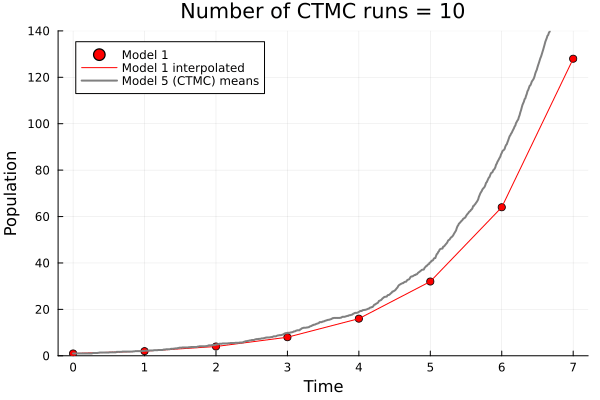

In [44]:
anim = Animation()
for N in [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000]
    Random.seed!(0)
    trajs = [model_5_traj() for _ in 1:N]
    means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
    plot(p2,t_grid,means,lw=2,c=:grey,ylim=(0,140),label="Model 5 (CTMC) means", title = "Number of CTMC runs = $N")
    frame(anim)
end

gif(anim, "sampleAnim.gif", fps = 1.5)

# Model 6 - Agent/Discrete-Event

In [45]:
function model_6_traj(;t_max = default_t_max, x0 = default_x0, life_time_till_doubling_dist = Exponential(1/κ_const) )
    population = BinaryMinHeap{Float64}()
    for _ in x0
        push!(population, rand(life_time_till_doubling_dist) )
    end
    current_time = 0.0
    t_values, u_values = [current_time], [length(population)]

    while current_time <= t_max 
        current_time = pop!(population)
        for _ in 1:2
            push!(population, current_time + rand(life_time_till_doubling_dist) )
        end
        push!(t_values, current_time)
        push!(u_values, length(population))
    end
    return ModelTrajectory(t_values, u_values)
end

model_6_traj (generic function with 1 method)

In [46]:
traj6_repeats = [model_6_traj() for _ in 1:10];
traj6_repeats_stiched = stich_steps.(traj6_repeats);

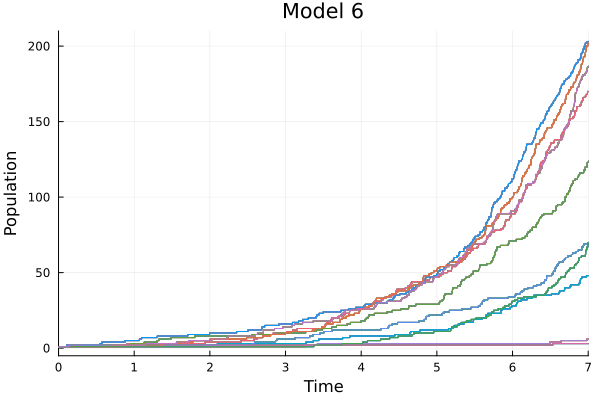

In [47]:
times = [mt.t for mt in traj6_repeats_stiched]
vals = [mt.u for mt in traj6_repeats_stiched]
p = plot(title = "Model 6")
for i in 1:length(times)
    plot!(times,vals;plot_args...,xlim=(0,7))
end
p

  0.039472 seconds (52.49 k allocations: 10.686 MiB, 55.73% compilation time)


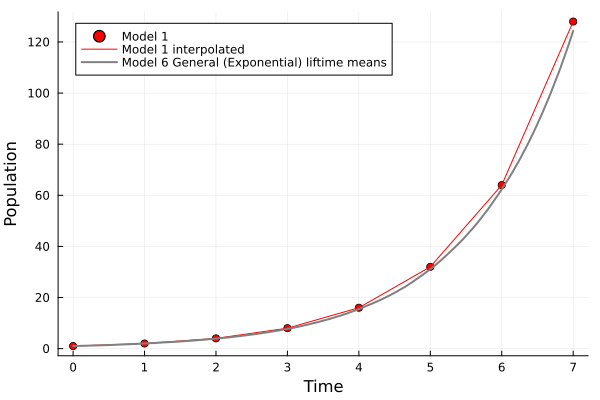

In [48]:
@time trajs = [model_6_traj() for _ in 1:10^3]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
p7 = plot(p2,t_grid,means,lw=2,c=:grey,label="Model 6 General (Exponential) liftime means")

But if we change the liftime distribution shape things change...

In [49]:
default_dist = Exponential(1/κ_const)
new_dist = Uniform(0,2/κ_const)
mean(default_dist), mean(new_dist)

(1.4426950408889634, 1.4426950408889634)

  0.113066 seconds (169.27 k allocations: 11.201 MiB, 93.18% compilation time)


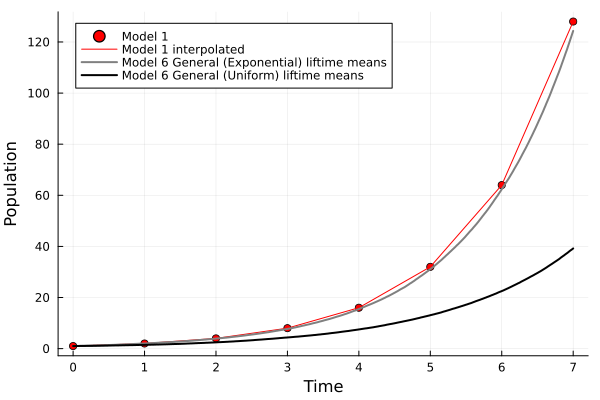

In [50]:
@time trajs = [model_6_traj(life_time_till_doubling_dist=new_dist) for _ in 1:10^3]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
plot(p7,t_grid,means,lw=2,c=:black,label="Model 6 General (Uniform) liftime means")

# Challange

Try to "calibrate" Model 6 so that it behaves on average like the other models.

# Reading results from file

In [51]:
pwd()

"/Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists"

In [52]:
readdir()

10-element Vector{String}:
 ".git"
 ".gitignore"
 ".ipynb_checkpoints"
 "Manifest.toml"
 "Project.toml"
 "README.md"
 "TheDoublingPopulation.ipynb"
 "demo_julia_syntax.jl"
 "model4.csv"
 "sampleAnim.gif"

In [53]:
df = CSV.File("model4.csv") |> DataFrame

Row,Time0_0,Time2_5,Time5_0,Time5_9,Time6_7
,Float64,Float64,Float64,Float64,Float64
1,1.01142,6.56628,35.9969,65.2706,110.689
2,1.38125,4.23526,16.1835,30.6798,53.9986
3,2.08504,12.972,65.8557,121.738,208.836
4,0.299317,7.08686,46.4637,85.5353,148.377
5,0.622008,0.0,0.0,0.0,0.0
6,1.17725,5.94175,34.9634,64.4548,112.909
7,1.72367,8.41011,45.7651,85.0796,147.745
8,1.00608,0.0,0.0,0.0,0.0
9,0.662608,5.62962,27.1654,49.4605,85.3998


In [54]:
using StatsBase

In [55]:
summarystats(df.Time5_0)

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           33.019491
Minimum:        0.000000
1st Quartile:   0.000000
Median:         28.523460
3rd Quartile:   56.030906
Maximum:        161.187689


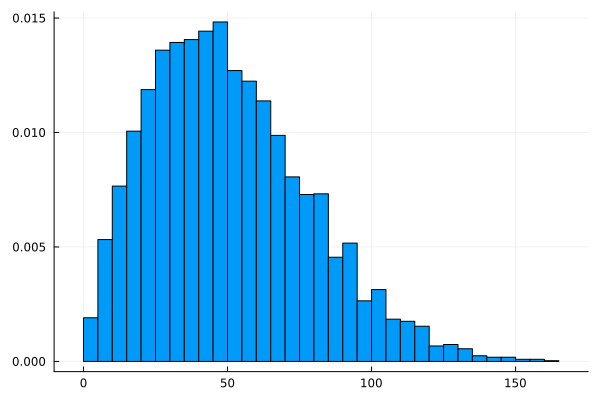

In [56]:
histogram(filter((x)->x>0,df.Time5_0), label=false, normed=true)

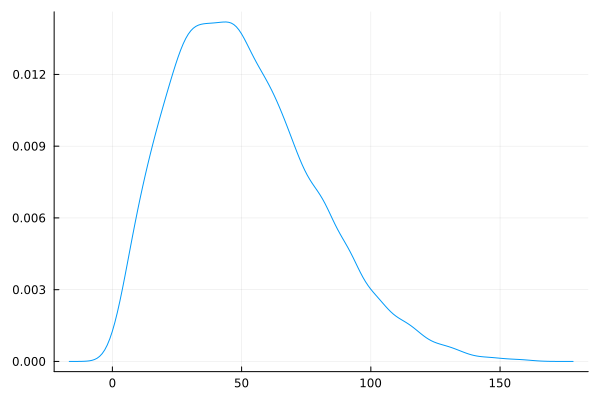

In [57]:
density(filter((x)->x>0,df.Time5_0), label=false)

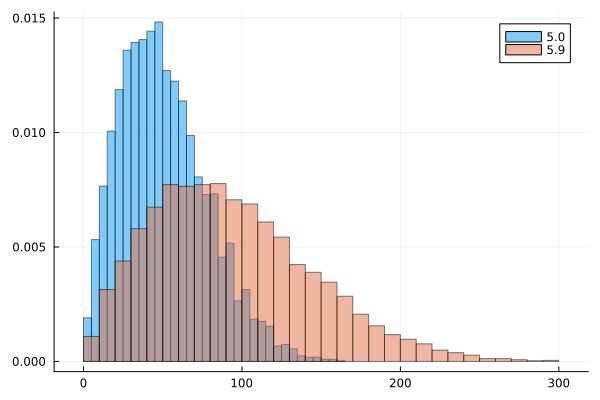

In [58]:
histogram([filter((x)->x>0,df.Time5_0),filter((x)->x>0,df.Time5_9)], label=["5.0" "5.9"], normed=true,alpha=0.5)

# Exercise

Create an animation of the distribution of the population size of time. Compare animations for the various models.

# HeatMap

In [86]:
typeof(Int[])

Vector{Int64} (alias for Array{Int64, 1})

In [90]:
# data = [(i+j)^2 for i in 1:100, j in 1:100]
data =zeros(100,100)
for i in 1:100
    for j in 1:100
        data[i,j] =i + j
    end
end
data

100×100 Matrix{Float64}:
   2.0    3.0    4.0    5.0    6.0  …   97.0   98.0   99.0  100.0  101.0
   3.0    4.0    5.0    6.0    7.0      98.0   99.0  100.0  101.0  102.0
   4.0    5.0    6.0    7.0    8.0      99.0  100.0  101.0  102.0  103.0
   5.0    6.0    7.0    8.0    9.0     100.0  101.0  102.0  103.0  104.0
   6.0    7.0    8.0    9.0   10.0     101.0  102.0  103.0  104.0  105.0
   7.0    8.0    9.0   10.0   11.0  …  102.0  103.0  104.0  105.0  106.0
   8.0    9.0   10.0   11.0   12.0     103.0  104.0  105.0  106.0  107.0
   9.0   10.0   11.0   12.0   13.0     104.0  105.0  106.0  107.0  108.0
  10.0   11.0   12.0   13.0   14.0     105.0  106.0  107.0  108.0  109.0
  11.0   12.0   13.0   14.0   15.0     106.0  107.0  108.0  109.0  110.0
  12.0   13.0   14.0   15.0   16.0  …  107.0  108.0  109.0  110.0  111.0
  13.0   14.0   15.0   16.0   17.0     108.0  109.0  110.0  111.0  112.0
  14.0   15.0   16.0   17.0   18.0     109.0  110.0  111.0  112.0  113.0
   ⋮                      

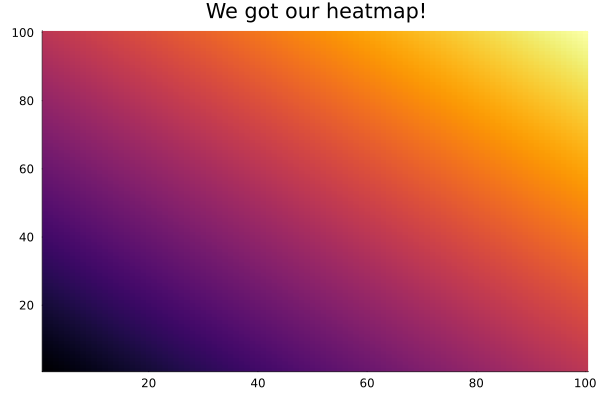

In [92]:
heatmap(data,legend=false, title = "We got our heatmap!")